#Import libraries

In [24]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from tqdm import tqdm

# 2. Fetch the Dataset

*   ESC-50: a dataset for Environmental Sound Classification (https://github.com/karolpiczak/ESC-50, https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf)
 * 50 classes,  40 files per class, 5s clips
*   Download & unzip the dataset running the cell below. This will take a minute. You will see the new files on the left (folder icon).

In [2]:
#!wget https://github.com/karolpiczak/ESC-50/archive/master.zip
#!unzip master.zip
#!rm master.zip

--2025-03-29 14:29:34--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Risoluzione di github.com (github.com)... 140.82.121.4
Connessione a github.com (github.com)|140.82.121.4|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [segue]
--2025-03-29 14:29:34--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Risoluzione di codeload.github.com (codeload.github.com)... 140.82.121.9
Connessione a codeload.github.com (codeload.github.com)|140.82.121.9|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: non specificato [application/zip]
Salvataggio in: «master.zip»

master.zip              [   <=>              ] 511,60M  15,2MB/s               ^C
Archive:  master.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case

---

# 3. Metadata and analysis I

***Tasks:***
* Use pandas to read the csv file in *ESC-50-master/meta/*
* Print the first elements of the csv. Pandas has a standard function for this.
* Print the list of *unique* class labels in the dataset, and check whether there really are 50 of them

In [4]:
# Setup some filepaths
fn = 'ESC-50-master/meta/esc50.csv'

df = pd.read_csv(fn)
df.head()

unique_categories = np.unique(df['category'])
print(unique_categories)
print(len(unique_categories))

['airplane' 'breathing' 'brushing_teeth' 'can_opening' 'car_horn' 'cat'
 'chainsaw' 'chirping_birds' 'church_bells' 'clapping' 'clock_alarm'
 'clock_tick' 'coughing' 'cow' 'crackling_fire' 'crickets' 'crow'
 'crying_baby' 'dog' 'door_wood_creaks' 'door_wood_knock'
 'drinking_sipping' 'engine' 'fireworks' 'footsteps' 'frog'
 'glass_breaking' 'hand_saw' 'helicopter' 'hen' 'insects'
 'keyboard_typing' 'laughing' 'mouse_click' 'pig' 'pouring_water' 'rain'
 'rooster' 'sea_waves' 'sheep' 'siren' 'sneezing' 'snoring' 'thunderstorm'
 'toilet_flush' 'train' 'vacuum_cleaner' 'washing_machine' 'water_drops'
 'wind']
50


---

# 4. Metadata and analysis II

* View and listen to some examples in the dataset to get a "feeling" for the sound classes.

dog
chirping_birds
vacuum_cleaner


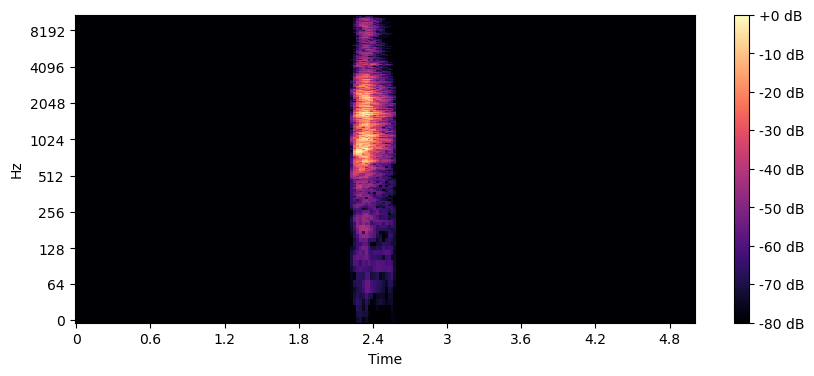

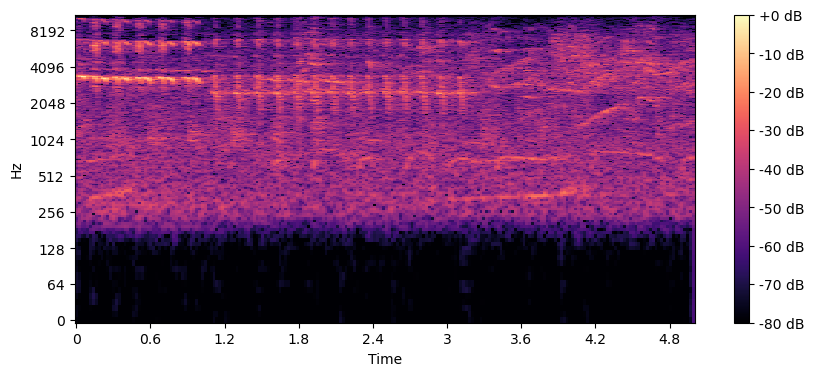

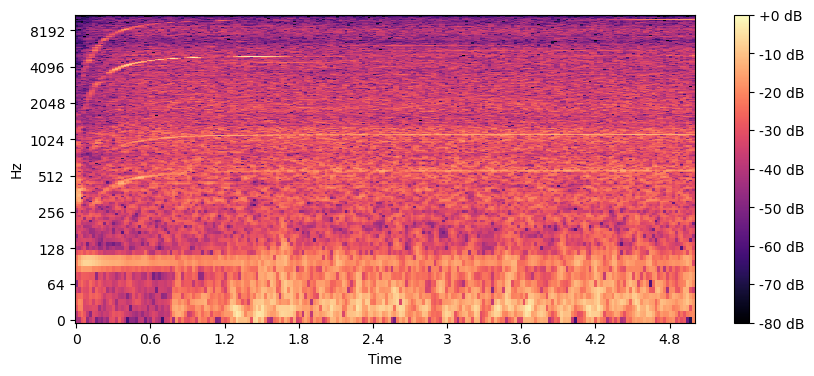

In [5]:
# Show audio player for each file
audio_path = 'ESC-50-master/audio/'
audio0 = audio_path + df['filename'][0]
audio1 = audio_path + df['filename'][1]
audio2 = audio_path + df['filename'][2]

print(df['category'][0])
print(df['category'][1])
print(df['category'][2])

IPython.display.display(IPython.display.Audio(audio0))
IPython.display.display(IPython.display.Audio(audio1))
IPython.display.display(IPython.display.Audio(audio2))

# Plot STFT specs
y0, sr0 = librosa.load(audio0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y0)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr0, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

y1, sr1 = librosa.load(audio1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr1, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

y2, sr2 = librosa.load(audio2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y2)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr2, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()



---

# 5. ESC-5: Curation

Let's select 5 classes (*our_classes*) from ESC-50 to make things a bit faster.

***Tasks:***
* Collect all files that belong to *our_classes*.
* Put the files and their respective classes in separate lists. Make sure their indices are equal (meaning: the value at index 3 of list *A* is related to the value at index 3 of list *B*).
  * Idea 1: Use *df.values* to iterate over the rows of the csv
  * Idea 2: Use *df.query('category in @our_classes')*
* Print the first 5 elements of each list as (file, class)-tuples. Also, print the overall lengths of the lists.

In [6]:
#print(np.unique(df['category']))

selected_classes = ['crying_baby','dog','rain','rooster','sneezing']

esc5_files = []
esc5_classes = []

df2 = df.query('category in @selected_classes')
esc5_files = df2['filename'].values
esc5_classes = df2['category'].values

print(list(zip(esc5_files[:5], esc5_classes[:5])))
print(f'Lenght esc5_files: {len(esc5_files)}, Lenght esc5_classes: {len(esc5_classes)}')


[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lenght esc5_files: 200, Lenght esc5_classes: 200


---

# 6. ESC-5: Dataset splitting

***Tasks:***
* Split the dataset into *train* and *test* subsets: split ratio is 80%/20%, and random state 1337.
  * Use a suitable straight-forward function from sklearn.
* Print the first 3 elements of the resulting *X_train*.
* Print the overall lengths of the resulting lists. Are they aligned with the ratio?

Result: ESC-5 is ready. We have a train and test set consisting of file lists and their respective classes.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(esc5_files, esc5_classes,
                                                    train_size=0.8,
                                                    test_size=0.2, random_state=1337)

print(list(zip(X_train[:3], y_train[:3])))
print(f'Lenght X_train: {len(X_train)}, Lenght y_train: {len(y_train)}')
print(f'Lenght Y_test: {len(X_test)}, Lenght y_test: {len(y_test)}')


[('5-203128-A-0.wav', 'dog'), ('4-181286-A-10.wav', 'rain'), ('3-157615-A-10.wav', 'rain')]
Lenght X_train: 160, Lenght y_train: 160
Lenght Y_test: 40, Lenght y_test: 40


---
# 7. ESC-5: Create mel spectrograms

We need to compute features and corresponding labels for each file in our ESC-5.

***Tasks:***
* Define a function that does the following (in this order!):
  * takes input parameters: *X_train* (list of filenames), *y_train* (list of classes)
  * loops over *X_train* (hint: *enumerate* it), and loads each file (.wav) using librosa
  * creates the mel spectrogram from the loaded .wav samples
  * normalizes the mel spec by dividing it through the number of given *mel_bands*.
  * transposes the mel spec
  * appends the features (mel spec) to a feature tensor
  * creates a target vector consisting of as many values as there are frames
    * hint: use .shape to see which value you need
  * each value inside the vector must correspond to the index of the class in *our_classes*
    * hint: remember *numpy.ones(...)* ?
    * hint: use *.index(...)* here. Not ideal, but works here.
  * appends the targets to a target tensor
  * stacks the large feature and target lists appropriately
  * returns the tensors
* Finally, print the shapes of all 4 arrays.

In [8]:
def extract_mel_features(X_train, y_train):
  X = [] # X is the feature tensor
  y = []

  mel_bands = 128
  for i, file in enumerate(tqdm(X_train)):
    signal, sr = librosa.load(audio_path + file)
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=mel_bands)
    mel_spec /= mel_bands
    mel_spec = mel_spec.T
    X.append(mel_spec) # X is the feature tensor

    # Categorical label
    y.append(np.ones(mel_spec.shape[0]) * selected_classes.index(y_train[i]))

  X = np.vstack(X) # Training Matrix
  y = np.hstack(y) # Vector

  return X, y

X_train_ready, y_train_ready = extract_mel_features(X_train, y_train)
X_test_ready, y_test_ready = extract_mel_features(X_test, y_test)




100%|██████████| 40/40 [00:00<00:00, 79.14it/s]


Shape X_train_ready: (34560, 128)
Shape y_train_ready: (34560,)
Shape X_test_ready: (8640, 128)
Shape y_test_ready: (8640,)


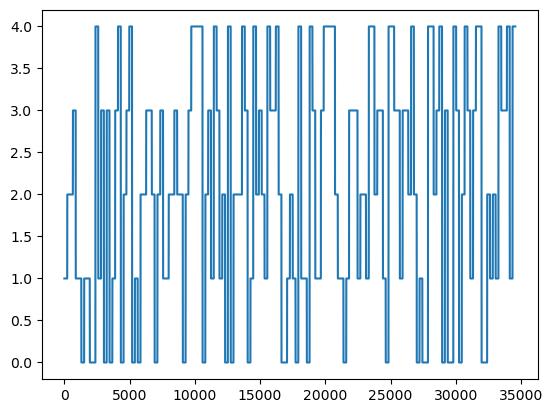

In [9]:
print(f'Shape X_train_ready: {X_train_ready.shape}')
print(f'Shape y_train_ready: {y_train_ready.shape}')
print(f'Shape X_test_ready: {X_test_ready.shape}')
print(f'Shape y_test_ready: {y_test_ready.shape}')

plt.plot(y_train_ready)

In [10]:
np.isnan(X_train_ready)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

---

# 8. ESC-5: Train a nearest neighbor classifier

***Tasks:***
* Standardize the features from step 7 using sklearn.
* Use the features and targets to train (*fit*) a kNN-classifier from sklearn, with 5 neighbors and uniform weighting.
* Print the scores on the train set and test set, rounded to 4 decimals. (This will take some time!)


In [11]:
print('Scaling ...')
scaler = StandardScaler()
scaler.fit(X_train_ready)

X_train_scaled = scaler.transform(X_train_ready)
X_test_scaled = scaler.transform(X_test_ready)

Scaling ...


In [12]:
print('Classification ...')
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train_scaled, y_train_ready)

print('Evaluation')
print(f'Train score: {np.round(knn.score(X_train_scaled, y_train_ready), decimals=4)}')
print(f'Test score: {np.round(knn.score(X_test_scaled, y_test_ready), decimals=4)}')

Classification ...
Evaluation


/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Train score: 0.73
Test score: 0.5198


---

# 9. ESC-5: Plot the confusion matrix
We want to learn more about our classifier. How well does it perform per class?

***Tasks:***
* Using scikit-learn, create a confusion matrix of our classifier over the test set
* Normalize the rows, use 'our_classes' as axes tick values
* Display the plot

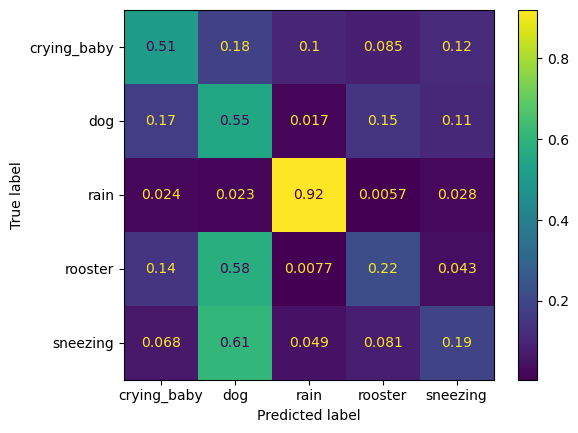

In [13]:
cm = confusion_matrix(y_true=y_test_ready, y_pred=knn.predict(X_test_scaled), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
disp.plot()
plt.show()


Extra work

100%|██████████| 40/40 [00:00<00:00, 102.45it/s]



 KNN (C=1) with 10 MFCC:
Train Accuracy: 0.9681
Test Accuracy: 0.6056
Generalization Gap: 0.3625


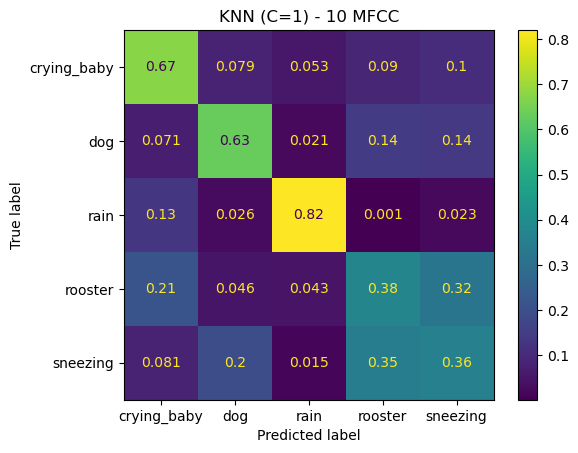


 SVM Linear (C=1) with 10 MFCC:
Train Accuracy: 0.6483
Test Accuracy: 0.6157
Generalization Gap: 0.0326


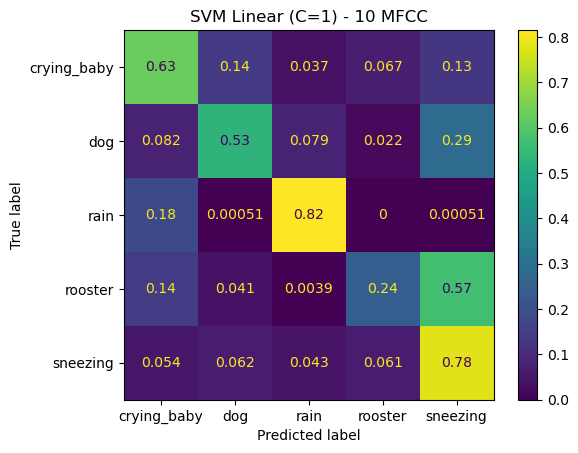


 SVM RBF (C=1) with 10 MFCC:
Train Accuracy: 0.7841
Test Accuracy: 0.6426
Generalization Gap: 0.1415


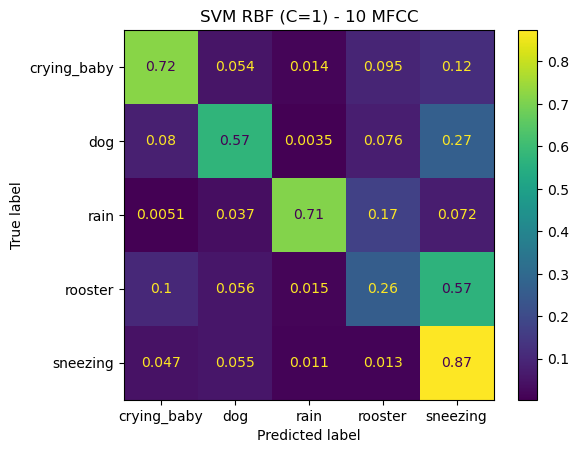


 Logistic Regression (C=1) with 10 MFCC:
Train Accuracy: 0.6338
Test Accuracy: 0.6057
Generalization Gap: 0.0281


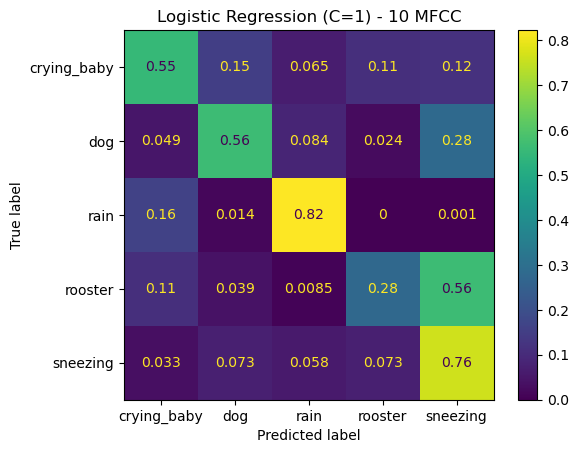


 Random Forest (C=N/A) with 10 MFCC:
Train Accuracy: 1.0000
Test Accuracy: 0.6182
Generalization Gap: 0.3818


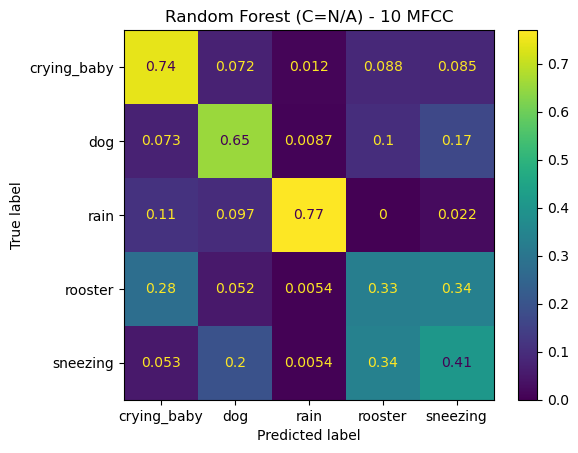


 KNN (C=10) with 10 MFCC:
Train Accuracy: 0.9681
Test Accuracy: 0.6056
Generalization Gap: 0.3625


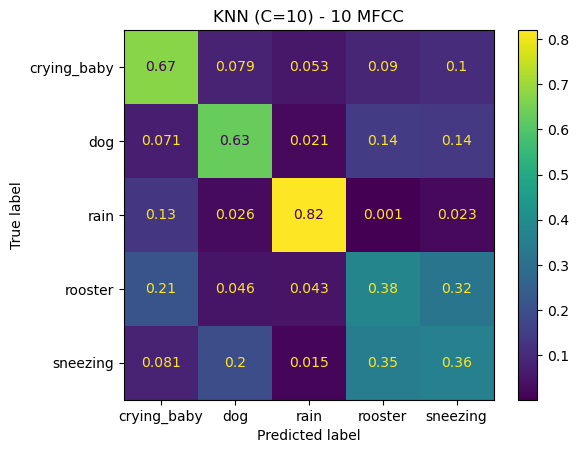


 SVM Linear (C=10) with 10 MFCC:
Train Accuracy: 0.6484
Test Accuracy: 0.6159
Generalization Gap: 0.0325


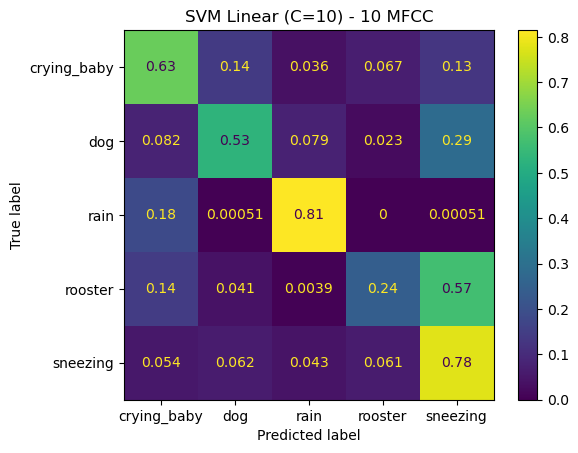


 SVM RBF (C=10) with 10 MFCC:
Train Accuracy: 0.8125
Test Accuracy: 0.6280
Generalization Gap: 0.1845


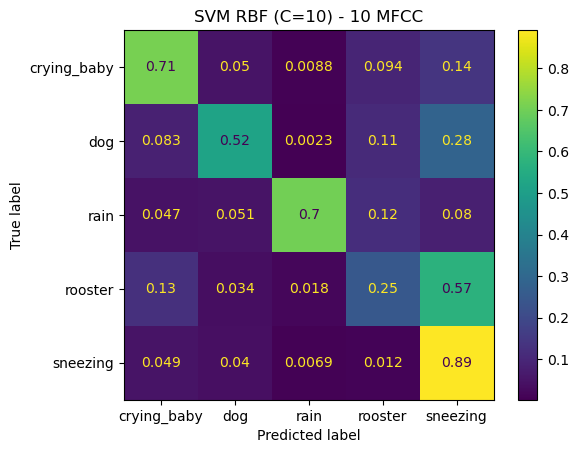


 Logistic Regression (C=10) with 10 MFCC:
Train Accuracy: 0.6339
Test Accuracy: 0.6056
Generalization Gap: 0.0283


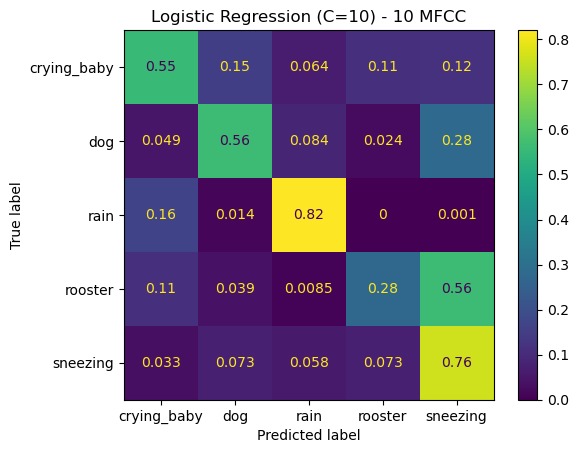


 Random Forest (C=N/A) with 10 MFCC:
Train Accuracy: 1.0000
Test Accuracy: 0.6182
Generalization Gap: 0.3818


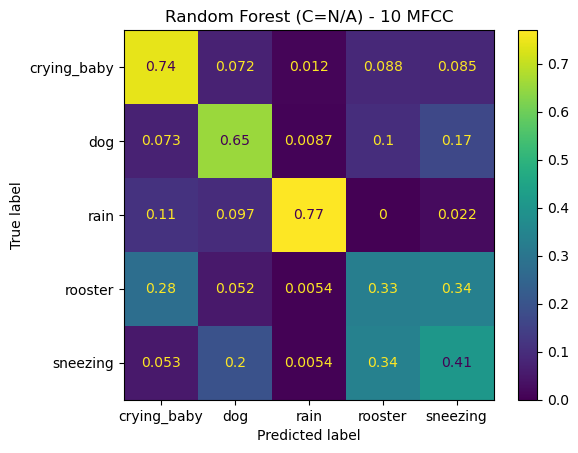


 KNN (C=1) with 20 MFCC:
Train Accuracy: 0.9770
Test Accuracy: 0.6127
Generalization Gap: 0.3643


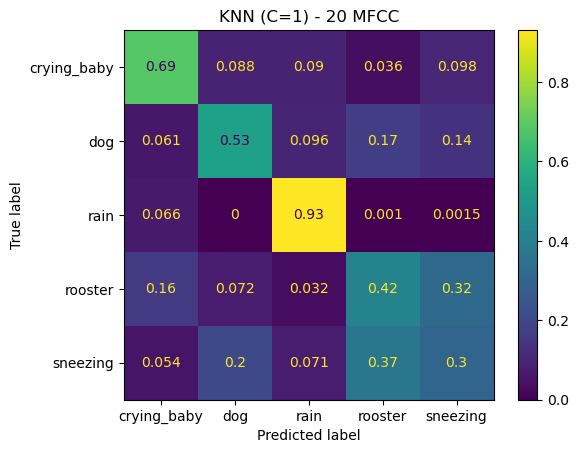


 SVM Linear (C=1) with 20 MFCC:
Train Accuracy: 0.6674
Test Accuracy: 0.6272
Generalization Gap: 0.0402


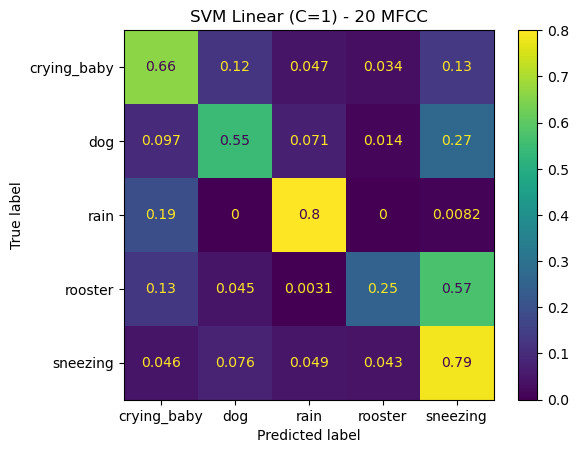


 SVM RBF (C=1) with 20 MFCC:
Train Accuracy: 0.8113
Test Accuracy: 0.7039
Generalization Gap: 0.1073


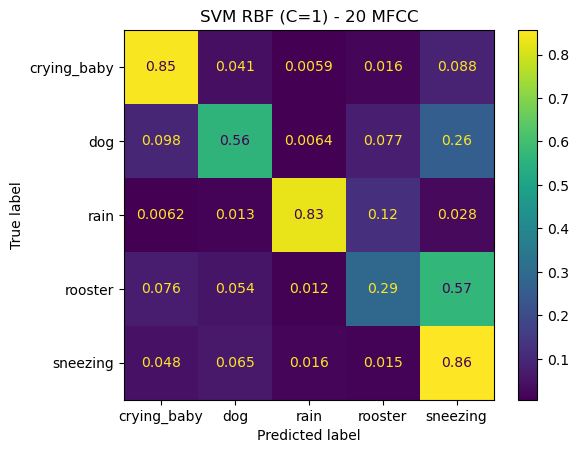


 Logistic Regression (C=1) with 20 MFCC:
Train Accuracy: 0.6458
Test Accuracy: 0.6306
Generalization Gap: 0.0152


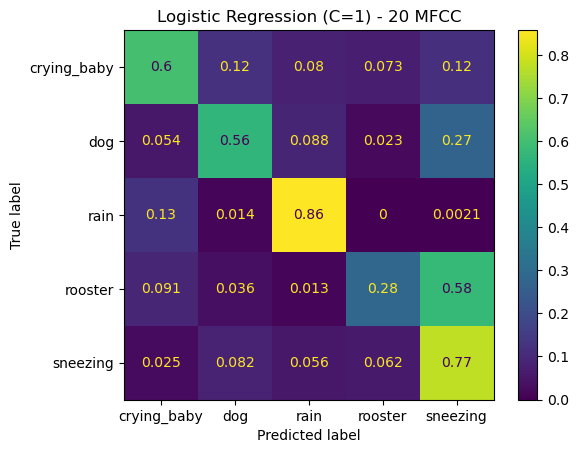


 Random Forest (C=N/A) with 20 MFCC:
Train Accuracy: 1.0000
Test Accuracy: 0.6730
Generalization Gap: 0.3270


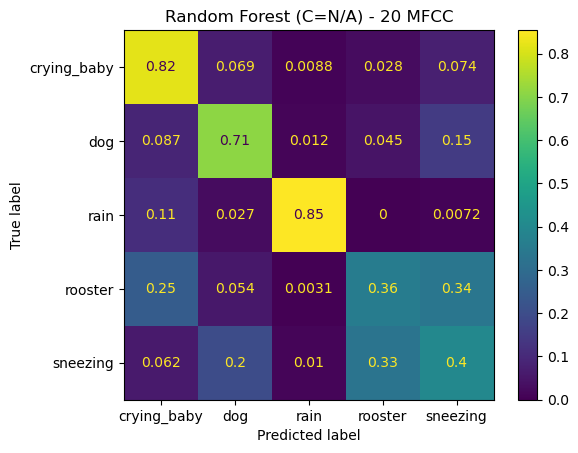


 KNN (C=10) with 20 MFCC:
Train Accuracy: 0.9770
Test Accuracy: 0.6127
Generalization Gap: 0.3643


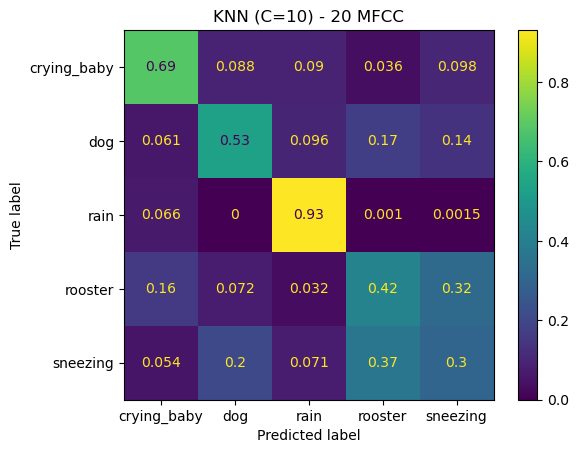


 SVM Linear (C=10) with 20 MFCC:
Train Accuracy: 0.6673
Test Accuracy: 0.6273
Generalization Gap: 0.0400


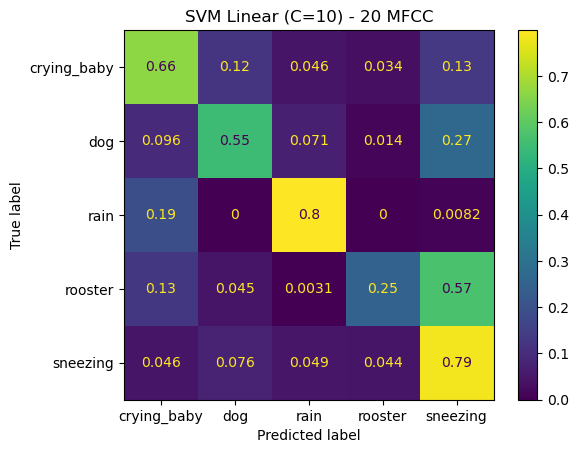


 SVM RBF (C=10) with 20 MFCC:
Train Accuracy: 0.8349
Test Accuracy: 0.6769
Generalization Gap: 0.1580


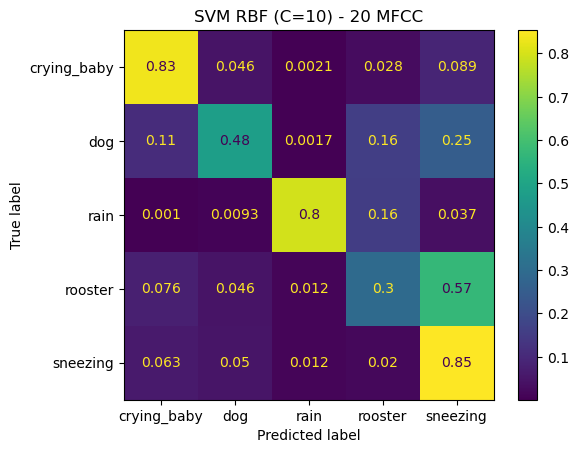


 Logistic Regression (C=10) with 20 MFCC:
Train Accuracy: 0.6457
Test Accuracy: 0.6302
Generalization Gap: 0.0155


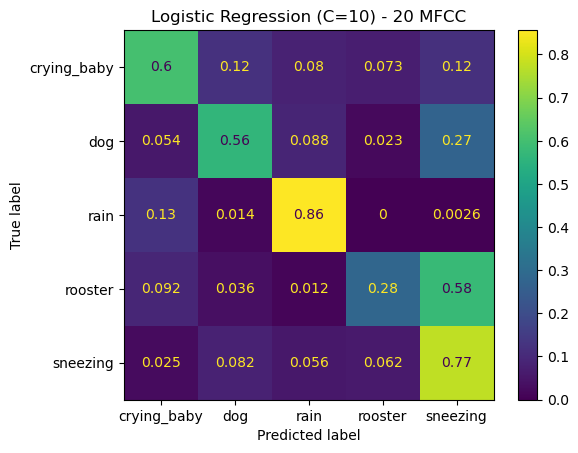


 Random Forest (C=N/A) with 20 MFCC:
Train Accuracy: 1.0000
Test Accuracy: 0.6730
Generalization Gap: 0.3270


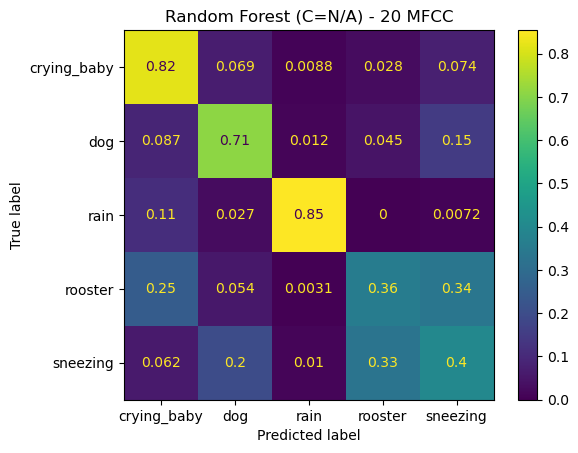

,Model,MFCC,Train Accuracy,Test Accuracy,Generalization Gap
0,KNN (C=1),10,0.9681,0.6056,0.3625
1,SVM Linear (C=1),10,0.6483,0.6157,0.0326
2,SVM RBF (C=1),10,0.7841,0.6426,0.1415
3,Logistic Regression (C=1),10,0.6338,0.6057,0.0281
4,Random Forest (C=N/A),10,1.0000,0.6182,0.3818
5,KNN (C=10),10,0.9681,0.6056,0.3625
6,SVM Linear (C=10),10,0.6484,0.6159,0.0325
7,SVM RBF (C=10),10,0.8125,0.6280,0.1845
8,Logistic Regression (C=10),10,0.6339,0.6056,0.0283
9,Random Forest (C=N/A),10,1.0000,0.6182,0.3818


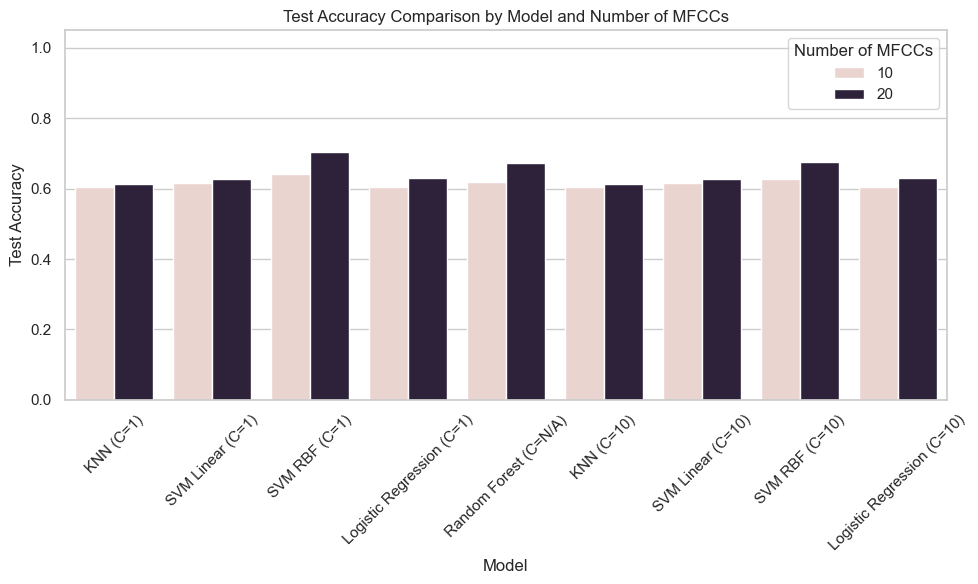

In [25]:
def extract_mfcc_features(X_files, y_labels, n_mfcc=13):
    X = []
    y = []

    for i, file in enumerate(tqdm(X_files)):
        signal, sr = librosa.load(audio_path + file)
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T  # (frames, coeffs)
        X.append(mfcc)
        y.append(np.ones(mfcc.shape[0]) * selected_classes.index(y_labels[i]))

    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

X_train_10, y_train_10 = extract_mfcc_features(X_train, y_train, n_mfcc=10)
X_test_10, y_test_10 = extract_mfcc_features(X_test, y_test, n_mfcc=10)

X_train_20, y_train_20 = extract_mfcc_features(X_train, y_train, n_mfcc=20)
X_test_20, y_test_20 = extract_mfcc_features(X_test, y_test, n_mfcc=20)




scaler_10 = StandardScaler()
X_train_10_scaled = scaler_10.fit_transform(X_train_10)
X_test_10_scaled = scaler_10.transform(X_test_10)

scaler_20 = StandardScaler()
X_train_20_scaled = scaler_20.fit_transform(X_train_20)
X_test_20_scaled = scaler_20.transform(X_test_20)


results_summary = []

def train_and_evaluate(X_train, y_train, X_test, y_test, model, model_name, mfcc_count):
    print(f"\n {model_name} with {mfcc_count} MFCC:")
    
    model.fit(X_train, y_train)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    generalization_gap = round(train_score - test_score, 4)

    print(f"Train Accuracy: {train_score:.4f}")
    print(f"Test Accuracy: {test_score:.4f}")
    print(f"Generalization Gap: {generalization_gap:.4f}")

    results_summary.append({
        'Model': model_name,
        'MFCC': mfcc_count,
        'Train Accuracy': round(train_score, 4),
        'Test Accuracy': round(test_score, 4),
        'Generalization Gap': generalization_gap
    })


    # Confusion matrix
    cm = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=selected_classes)
    disp.plot()
    plt.title(f"{model_name} - {mfcc_count} MFCC")
    plt.show()

models_C1 = [
    (KNeighborsClassifier(n_neighbors=5), "KNN (C=1)"),
    (SVC(kernel='linear', C=1.0), "SVM Linear (C=1)"),
    (SVC(kernel='rbf', C=1.0), "SVM RBF (C=1)"),
    (LogisticRegression(C=1.0, max_iter=1000), "Logistic Regression (C=1)"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest (C=N/A)")
]
models_C10 = [
    (KNeighborsClassifier(n_neighbors=5), "KNN (C=10)"),
    (SVC(kernel='linear', C=10), "SVM Linear (C=10)"),
    (SVC(kernel='rbf', C=10), "SVM RBF (C=10)"),
    (LogisticRegression(C=10, max_iter=1000), "Logistic Regression (C=10)"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest (C=N/A)")
]

#MFCC=10

for model, name in models_C1:
    train_and_evaluate(X_train_10_scaled, y_train_10, X_test_10_scaled, y_test_10, model, name, mfcc_count=10)

for model, name in models_C10:
    train_and_evaluate(X_train_10_scaled, y_train_10, X_test_10_scaled, y_test_10, model, name, mfcc_count=10)


# MFCC = 20
for model, name in models_C1:
    train_and_evaluate(X_train_20_scaled, y_train_20, X_test_20_scaled, y_test_20, model, name, mfcc_count=20)

for model, name in models_C10:
    train_and_evaluate(X_train_20_scaled, y_train_20, X_test_20_scaled, y_test_20, model, name, mfcc_count=20)


results_df = pd.DataFrame(results_summary)
display(results_df)

# Set visual style
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(10, 6))

# Bar plot: Test Accuracy by Model and MFCC count
sns.barplot(data=results_df, x='Model', y='Test Accuracy', hue='MFCC')

# Chart title and labels
plt.title('Test Accuracy Comparison by Model and Number of MFCCs')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.05)  # Y-axis from 0 to 100%
plt.legend(title='Number of MFCCs')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()